<a href="https://colab.research.google.com/github/manaal-amir/DSA210_F1Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code block, I'm building a data processing pipeline to analyze Formula 1 race ratings. First, I import the necessary Python libraries and connect to Google Drive to access the data files. I then load four key datasets: race ratings, constructor standings, race details, and constructor information. After cleaning the data by renaming columns for clarity, I identify the winning constructor for each race (those finishing in position 1) and merge this information with the race ratings data. The merged dataset is sorted chronologically by year and race number to maintain proper season order. Finally, I save this enhanced dataset to a new Excel file and perform quality checks by examining the column structure, verifying successful merges, and reviewing a sample of the processed data. This pipeline transforms raw, scattered F1 data into an analysis-ready format that connects fan ratings with winning teams, enabling investigation of what factors influence race popularity and setting the stage for deeper statistical analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Read all the Excel files
ratings_path = '/content/drive/My Drive/DSA210/Project/aggregated_ratings.xlsx'
ratings_df = pd.read_excel(ratings_path)
#Renaming columns for clarification
ratings_df = ratings_df.rename(columns={
    'Y': 'year',
    'R': 'race_number'
})

cons_standings_path = '/content/drive/My Drive/DSA210/Project/constructor_standings.xlsx'
cons_standings_df = pd.read_excel(cons_standings_path)

races_path = '/content/drive/My Drive/DSA210/Project/races.xlsx'
races_df = pd.read_excel(races_path)

cons_path = '/content/drive/My Drive/DSA210/Project/constructors.xlsx'
cons_df = pd.read_excel(cons_path)

#Get the winners (position 1) and merge with races and constructors
winners_df = (
    cons_standings_df[cons_standings_df['position'] == 1]
    .merge(races_df[['raceId', 'year', 'name']], on=['raceId', 'year'])
    .merge(cons_df[['constructorId', 'name']], on='constructorId')
)


#Rename columns to avoid confusion
winners_df = winners_df.rename(columns={
    'name_x': 'race_name',
    'name_y': 'constructor_name'
})

#Merge with original ratings
ratings_with_winners = ratings_df.merge(
    winners_df[['year', 'race_name', 'constructor_name']],
    left_on=['year', 'Grand PrixNAME'],
    right_on=['year', 'race_name'],
    how='left'
)

#Sort by year and then race_number
ratings_with_winners = ratings_with_winners.sort_values(['year', 'race_number'])

#Save the updated dataframe
output_path = '/content/drive/My Drive/DSA210/Project/aggregated_ratings_with_winners.xlsx'
ratings_with_winners.to_excel(output_path, index=False)

#Print ALL column names of the merged dataframe
print("Full list of columns in the merged dataframe:")
for i, col in enumerate(ratings_with_winners.columns, 1):
    print(f"{i}. {col}")

#Verify the merge
print("\nTotal rows:", len(ratings_with_winners))
print("Rows with winning constructor:", ratings_with_winners['constructor_name'].notna().sum())

#Show a sample of the data with the new column
print("\nSample of the updated dataframe:")
print(ratings_with_winners.head(10))

Mounted at /content/drive
Full list of columns in the merged dataframe:
1. year
2. race_number
3. Grand PrixNAME
4. P1
5. P2
6. P3
7. RATING
8. race_name
9. constructor_name

Total rows: 202
Rows with winning constructor: 202

Sample of the updated dataframe:
    year  race_number         Grand PrixNAME         P1         P2  \
0   2008            1  Australian Grand Prix   Hamilton   Heidfeld   
10  2008            2   Malaysian Grand Prix  Raikkonen     Kubica   
11  2008            3     Bahrain Grand Prix      Massa  Raikkonen   
12  2008            4     Spanish Grand Prix  Raikkonen      Massa   
13  2008            5     Turkish Grand Prix      Massa   Hamilton   
14  2008            6      Monaco Grand Prix   Hamilton     Kubica   
15  2008            7    Canadian Grand Prix     Kubica   Heidfeld   
16  2008            8      French Grand Prix      Massa  Raikkonen   
17  2008            9     British Grand Prix   Hamilton   Heidfeld   
1   2008           10      German Grand 

Next, I transformed raw data into meaningful predictors (features) to improve model performance.  

Tranformed Features (Feature Engineering):  

Win Dominance (Categorical):  
dominant_1_2: Constructor took 1st and 2nd  
dominant_1_3: Constructor took 1st and 3rd  
competitive_podium: Different constructors in all podium spots  

Season Progress (0-1):  
0.0 = First race of season  
1.0 = Last race of season  

Podium Frequency:   
How often each P1/P2/P3 driver appears on podium that season  
Measures driver consistency  

In [2]:
#1. Win Dominance Feature (using podium positions)
def get_win_dominance(row):
    """Calculate how dominant the win was based on podium"""
    if pd.isna(row['P2']) or pd.isna(row['P1']):
        return np.nan
    if row['constructor_name'] in [row['P1'], row['P2']]:
        return 'dominant_1_2'
    elif row['constructor_name'] in [row['P1'], row['P3']]:
        return 'dominant_1_3'
    else:
        return 'competitive_podium'

ratings_with_winners['win_dominance'] = ratings_with_winners.apply(get_win_dominance, axis=1)

#2. Season Progress Feature
total_races = ratings_with_winners.groupby('year')['race_number'].max()

ratings_with_winners['season_progress'] = ratings_with_winners.apply(
    lambda row: row['race_number'] / total_races[row['year']],
    axis=1
)

#3. Podium Consistency Feature
for position in ['P1', 'P2', 'P3']:
    col_name = f'{position}_season_count'
    ratings_with_winners[col_name] = ratings_with_winners.groupby(
        ['year', position]
    )['race_number'].transform('count')

print("\nEngineered Features Created:")
print("- Win Dominance: Categorical (dominant_1_2, dominant_1_3, competitive_podium)")
print("- Season Progress: Continuous (0-1 scale)")
print("- P1/P2/P3 Season Count: Frequency of podium appearances")

#Show sample with new features
sample_cols = ['year', 'race_name', 'constructor_name',
               'win_dominance', 'season_progress', 'P1_season_count']
print("\nSample with new features:")
print(ratings_with_winners[sample_cols].head(10))

output_path = '/content/drive/My Drive/DSA210/Project/aggregated_ratings_with_winners.xlsx'
ratings_with_winners.to_excel(output_path, index=False)



Engineered Features Created:
- Win Dominance: Categorical (dominant_1_2, dominant_1_3, competitive_podium)
- Season Progress: Continuous (0-1 scale)
- P1/P2/P3 Season Count: Frequency of podium appearances

Sample with new features:
    year              race_name constructor_name       win_dominance  \
0   2008  Australian Grand Prix          McLaren  competitive_podium   
10  2008   Malaysian Grand Prix          McLaren  competitive_podium   
11  2008     Bahrain Grand Prix       BMW Sauber  competitive_podium   
12  2008     Spanish Grand Prix          Ferrari  competitive_podium   
13  2008     Turkish Grand Prix          Ferrari  competitive_podium   
14  2008      Monaco Grand Prix          Ferrari  competitive_podium   
15  2008    Canadian Grand Prix          Ferrari  competitive_podium   
16  2008      French Grand Prix          Ferrari  competitive_podium   
17  2008     British Grand Prix          Ferrari  competitive_podium   
1   2008      German Grand Prix          Ferra

Initial analysis of the 'Win Dominance' feature showed that all races in the dataset had a 'competitive_podium' structure, with no occurrences of dominant 1-2 or 1-3 finishes. As a result, this feature was excluded from further analysis due to lack of variability.

<ipython-input-3-4cb6c009f88f>:9: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  ax = sns.boxplot(data=ratings_with_winners,


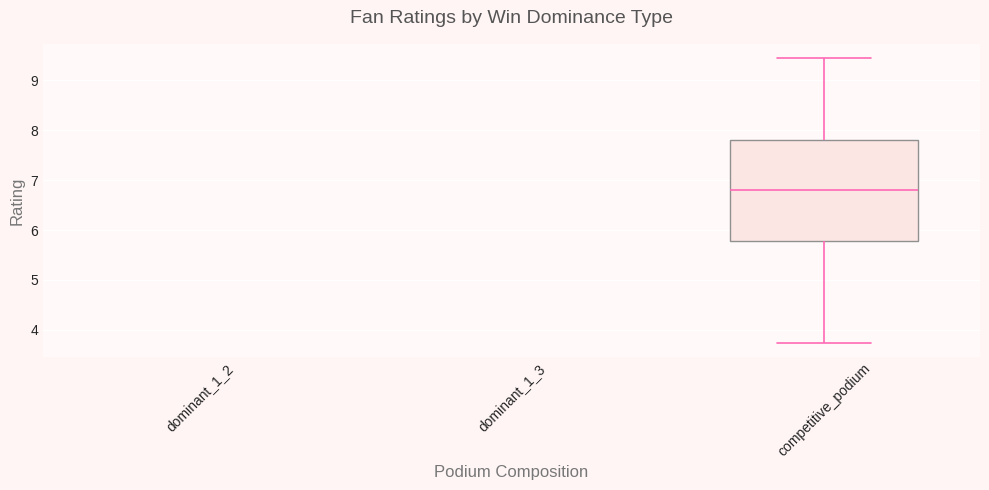

In [3]:
#1. Win Dominance Feature (using podium positions)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
soft_pinks = ['#FFE4E1', '#FFDAB9', '#FFC0CB']

plt.figure(figsize=(10, 5), facecolor='#FFF5F5')
ax = sns.boxplot(data=ratings_with_winners,
                 x='win_dominance',
                 y='RATING',
                 hue='win_dominance',
                 order=['dominant_1_2', 'dominant_1_3', 'competitive_podium'],
                 palette=soft_pinks,
                 width=0.6,
                 linewidth=1,
                 fliersize=4,
                 saturation=0.8,
                 legend=False)

plt.title('Fan Ratings by Win Dominance Type', pad=15, fontsize=14, color='#555555')
plt.xlabel('Podium Composition', fontsize=12, color='#777777')
plt.ylabel('Rating', fontsize=12, color='#777777')
plt.xticks(rotation=45)


for box in ax.artists:
    box.set_edgecolor('#FFB6C1')
    box.set_linewidth(0.8)

for line in ax.lines:
    line.set_color('#FF69B4')
    line.set_linewidth(1.2)

ax.yaxis.grid(True, color='white', linewidth=0.8)
sns.despine(left=True, bottom=True, trim=True)

ax.set_facecolor('#FFF9F9')

plt.tight_layout()
plt.show()

This visualization explores the relationship between fan ratings (RATING) and season progress (how far into the season a race occurs, scaled from 0 to 1). While a slight positive trend between season progress and ratings was observed, the wide confidence interval and high variability suggest that other factors play larger roles.

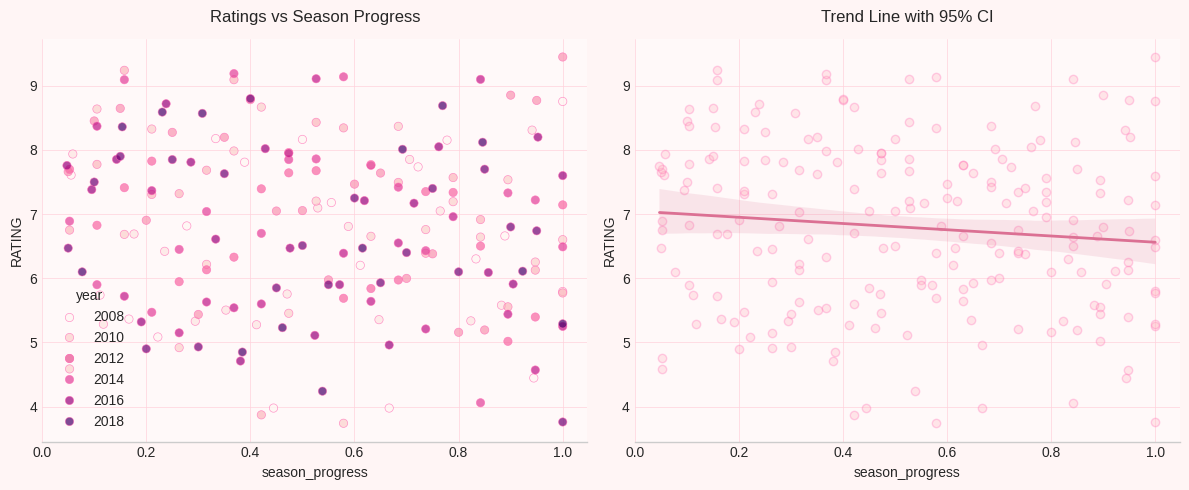

In [4]:
#2. Season Progress Effect
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette(["#FFB6C1", "#FF69B4", "#DB7093"]))
plt.figure(figsize=(12, 5), facecolor='#FFF5F5')

plt.subplot(1, 2, 1)
sns.scatterplot(data=ratings_with_winners,
               x='season_progress',
               y='RATING',
               hue='year',
               palette='RdPu',
               edgecolor='#FF69B4',
               alpha=0.7)
plt.title('Ratings vs Season Progress', pad=12)
plt.grid(color='#FFD1DC', linestyle='-', linewidth=0.5)

plt.subplot(1, 2, 2)
sns.regplot(data=ratings_with_winners,
           x='season_progress',
           y='RATING',
           scatter_kws={
               'color': '#FFB6C1',
               'alpha': 0.3,
               'edgecolor': '#FF69B4'
           },
           line_kws={
               'color': '#DB7093',
               'linewidth': 2
           })
plt.title('Trend Line with 95% CI', pad=12)
plt.grid(color='#FFD1DC', linestyle='-', linewidth=0.5)


for ax in plt.gcf().axes:
    ax.set_facecolor('#FFF9F9')
    sns.despine(left=True)

plt.tight_layout()
plt.show()


This output is from an Ordinary Least Squares (OLS) regression that tests whether season_progress (how far into the season a race occurs) has a statistically significant relationship with fan ratings (RATING).  
The regression analysis shows no statistically significant link between season_progress (how far into the season a race occurs) and fan ratings (RATING).
The extremely low R-squared (0.012) indicates that season_progress alone explains almost none of the variation in ratings.

In [5]:
import statsmodels.api as sm
#Regression: RATING ~ season_progress
X = sm.add_constant(ratings_with_winners['season_progress'])
model = sm.OLS(ratings_with_winners['RATING'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 RATING   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.341
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.128
Time:                        19:48:33   Log-Likelihood:                -339.13
No. Observations:                 202   AIC:                             682.3
Df Residuals:                     200   BIC:                             688.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.0481      0.190     

This heatmap answers "Does that dominance affect ratings?"
We analyzed whether a constructor's winning frequency (P1 finishes) affects race ratings, testing if fans prefer dominant teams or underdogs.    
The near-zero correlation (-0.015) revealed no link between a team's season-long winning frequency and race ratings.

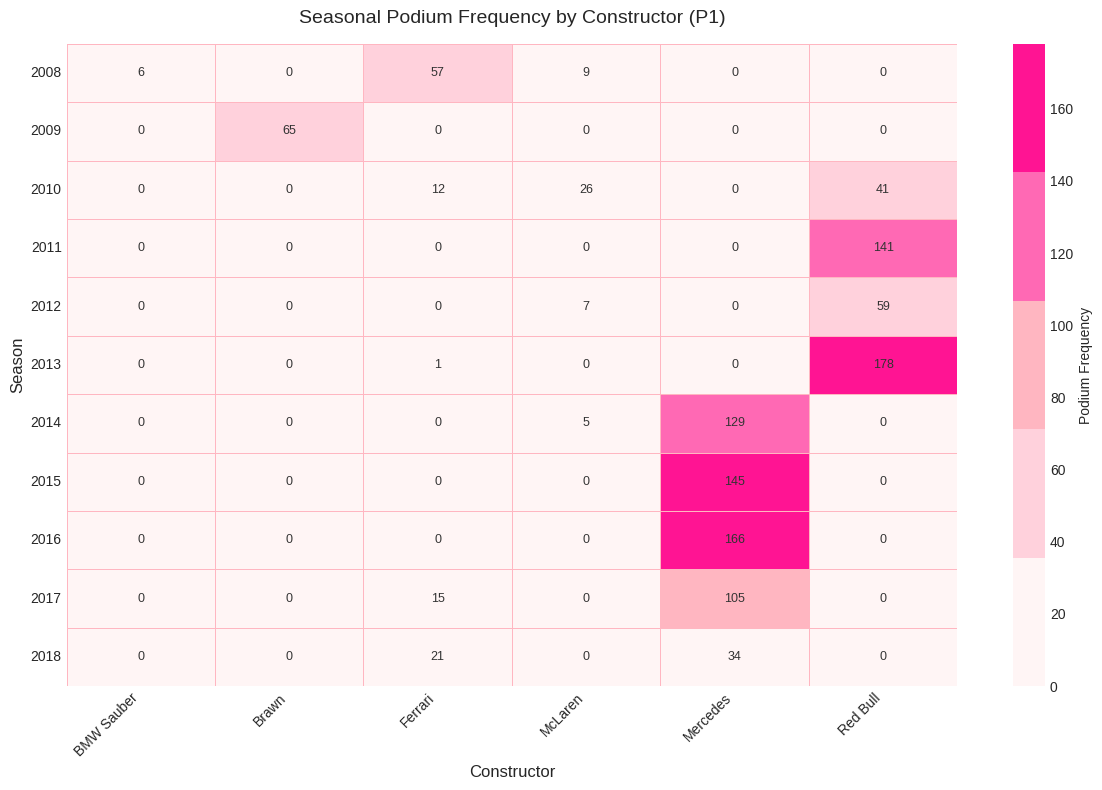

                 P1_season_total    RATING
P1_season_total         1.000000 -0.014696
RATING                 -0.014696  1.000000


In [6]:
pivot_data = ratings_with_winners.pivot_table(
    index='year',
    columns='constructor_name',
    values='P1_season_count',
    aggfunc='sum'
).fillna(0)


plt.figure(figsize=(12, 8))
pink_gradient = ["#FFF5F5", "#FFD1DC", "#FFB6C1", "#FF69B4", "#FF1493"]

sns.heatmap(pivot_data,
            annot=True,
            fmt='g',
            cmap=pink_gradient,
            linewidths=.5,
            linecolor='#FFB6C1',
            annot_kws={'color':'#333333', 'size':9},
            cbar_kws={'label':'Podium Frequency'})

plt.title('Seasonal Podium Frequency by Constructor (P1)', pad=15, fontsize=14)
plt.xlabel('Constructor', fontsize=12)
plt.ylabel('Season', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


merged_df = ratings_with_winners.merge(
    pivot_data.stack().reset_index(name='P1_season_total'),
    on=['year', 'constructor_name']
)

#Check correlation
print(merged_df[['P1_season_total', 'RATING']].corr())

Further features were crafted to test whether two driver-related features affect race ratings:  
podium_star_power: Combined popularity of P1/P2/P3 drivers  
rivalry_present: Whether known rivals (e.g., Hamilton vs. Rosberg) were on the podium

Correlation with Ratings:
 RATING               1.000000
podium_star_power   -0.082829
rivalry_present     -0.172649
Name: RATING, dtype: float64


<ipython-input-7-5fc5b13d62ab>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_with_drivers, x='rivalry_present', y='RATING',


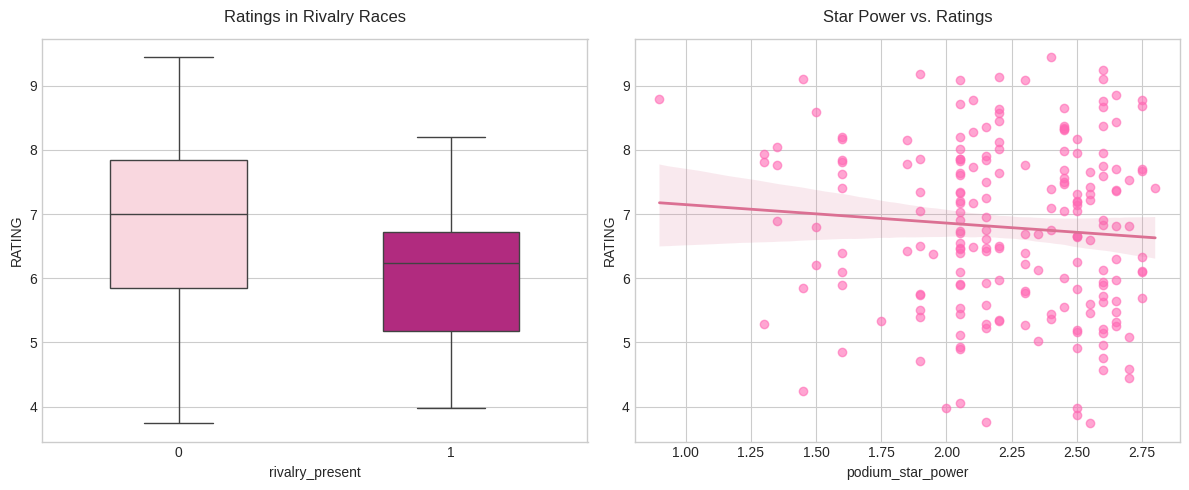

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#1. DRIVER FEATURE ENGINEERING (USING ONLY P1/P2/P3)
def create_driver_features(df):
    """
    Creates two guaranteed features:
    - rivalry_present: Binary flag for known rivalries in podium
    - podium_star_power: Aggregate star power of P1/P2/P3 (0-3 scale)
    """
    #Feature 1: Rivalry Indicator
    rivalry_pairs = {
        2008: [('Hamilton', 'Massa'), ('Hamilton', 'Raikkonen')],
        2010: [('Vettel', 'Webber'), ('Alonso', 'Webber')],
        2016: [('Hamilton', 'Rosberg')],
        2012: [('Vettel', 'Alonso')]
    }

    df['rivalry_present'] = df.apply(
        lambda x: 1 if any(
            {x['P1'], x['P2']} == set(pair)
            for pair in rivalry_pairs.get(x['year'], [])
        ) else 0,
        axis=1
    )

    #Feature 2: Podium Star Power
    star_weights = {
        'Hamilton': 1.0, 'Raikkonen': 0.9, 'Alonso': 0.9,
        'Vettel': 0.85, 'Massa': 0.8, 'Webber': 0.75,
        'Rosberg': 0.75, 'Button': 0.7, 'Kubica': 0.7
    }

    for pos in ['P1', 'P2', 'P3']:
        df[f'{pos}_star'] = df[pos].map(star_weights).fillna(0.3)  #Default for others

    df['podium_star_power'] = df['P1_star'] + df['P2_star'] + df['P3_star']

    return df


df_with_drivers = create_driver_features(ratings_with_winners.copy())

#3. ANALYSIS (ONLY USING CREATED FEATURES)
corr_matrix = df_with_drivers[['rivalry_present', 'podium_star_power', 'RATING']].corr()
print("Correlation with Ratings:\n", corr_matrix['RATING'].sort_values(ascending=False))

#4. VISUALIZATION
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_with_drivers, x='rivalry_present', y='RATING',
           palette=['#FFD1DC', '#C71585'], width=0.5)
plt.title("Ratings in Rivalry Races", pad=12)

plt.subplot(1, 2, 2)
sns.regplot(data=df_with_drivers, x='podium_star_power', y='RATING',
           scatter_kws={'color': '#FF69B4', 'alpha': 0.6},
           line_kws={'color': '#DB7093', 'linewidth': 2})
plt.title("Star Power vs. Ratings", pad=12)

plt.tight_layout()
plt.show()

Rivalry Races (Boxplot):  
Surprisingly, races with rivalries had lower median ratings (~6.0) than non-rivalry races (~6.5)   
Contradicts the hypothesis that rivalries boost engagement  
Star Power (Scatterplot):  
No clear trend between star power and ratings  
High-rated races occurred across all star power levels  

Next, I am checking for missing values and verifying that my merged and transformed dataset has none.

In [8]:
#Check total missing values per column
missing_values = ratings_with_winners.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values

#Check total missing values in the entire DataFrame
print(f"\nTotal missing values in DataFrame: {ratings_with_winners.isnull().sum().sum()}")

Missing values per column:
Series([], dtype: int64)

Total missing values in DataFrame: 0


This block analyzes F1 fan ratings by plotting their distribution and calculating the mean and median. First, it creates a histogram with a density curve to visualize the rating spread. Then it computes and displays both the average (mean) and middle value (median) of all ratings, providing key insights into the rating trends.

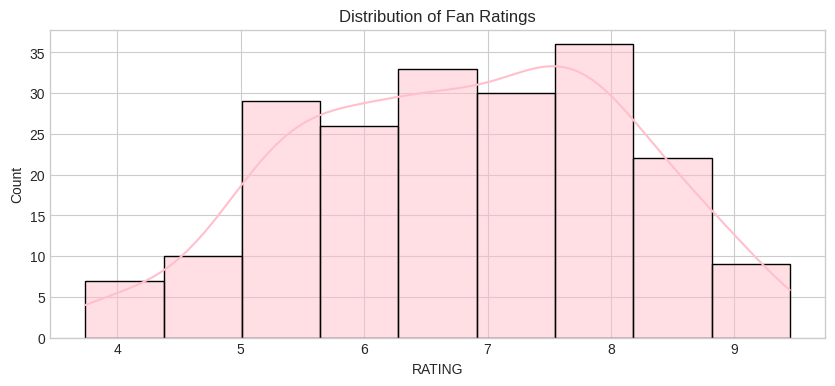

Mean rating: 6.79
Median rating: 6.81


In [9]:
#checking mean and median of ratings
#Check distribution first
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(10, 4))
sns.histplot(ratings_with_winners['RATING'], kde=True)
plt.title('Distribution of Fan Ratings')
plt.show()

#Calculate both
print(f"Mean rating: {ratings_with_winners['RATING'].mean():.2f}")
print(f"Median rating: {ratings_with_winners['RATING'].median():.2f}")

Similarly, for non numerical data, I found the mode.

In [10]:
#mode for most frequent winners
print("Most frequent winner (P1):", ratings_with_winners['P1'].mode()[0])
print("Most frequent constructor:", ratings_with_winners['constructor_name'].mode()[0])

Most frequent winner (P1): Hamilton
Most frequent constructor: Mercedes


Then I compare average F1 fan ratings across different groupings to identify trends. The code calculates and displays mean ratings in descending order for:

Constructors (winning teams)

Race locations (Grand Prix circuits)

Years (seasonal trends)

In [11]:
#compare mean ratings across groups
#By constructor
print(ratings_with_winners.groupby('constructor_name')['RATING'].mean().sort_values(ascending=False))
print()

#By race location
print(ratings_with_winners.groupby('Grand PrixNAME')['RATING'].mean().sort_values(ascending=False))
print()

#By year
print(ratings_with_winners.groupby('year')['RATING'].mean())

constructor_name
Red Bull      7.009778
McLaren       6.971071
Ferrari       6.914423
Mercedes      6.672506
Brawn         6.316176
BMW Sauber    5.364000
Name: RATING, dtype: float64

Grand PrixNAME
Azerbaijan Grand Prix       8.685000
United States Grand Prix    7.398000
British Grand Prix          7.363091
Canadian Grand Prix         7.330800
Chinese Grand Prix          7.263273
Brazilian Grand Prix        7.241200
Belgian Grand Prix          7.162091
Bahrain Grand Prix          7.120400
Australian Grand Prix       7.114727
Malaysian Grand Prix        7.047900
Hungarian Grand Prix        7.002727
German Grand Prix           7.002667
Turkish Grand Prix          6.845500
Austrian Grand Prix         6.836000
Korean Grand Prix           6.740000
Italian Grand Prix          6.688500
Japanese Grand Prix         6.435125
Singapore Grand Prix        6.374300
Spanish Grand Prix          6.354000
Monaco Grand Prix           6.344545
Abu Dhabi Grand Prix        6.166000
Mexican Grand Prix     

In the following parts, I have plotted my variables with respect to ratings to visualize and see if I can find some intuition about the data.

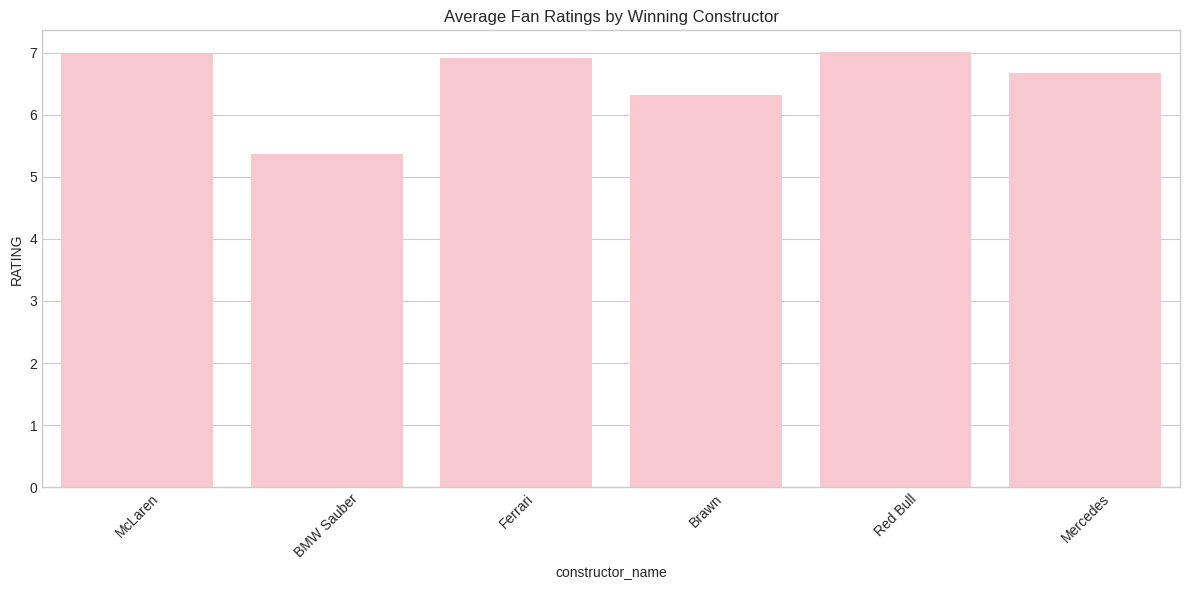

In [12]:
#Set style for better looking plots
original_palette = sns.color_palette()
sns.set_palette(["pink"])

#1. Ratings by Winning Constructor (bar plot)
plt.figure(figsize=(12, 6))
sns.barplot(x='constructor_name', y='RATING', data=ratings_with_winners, errorbar=None)
plt.title('Average Fan Ratings by Winning Constructor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

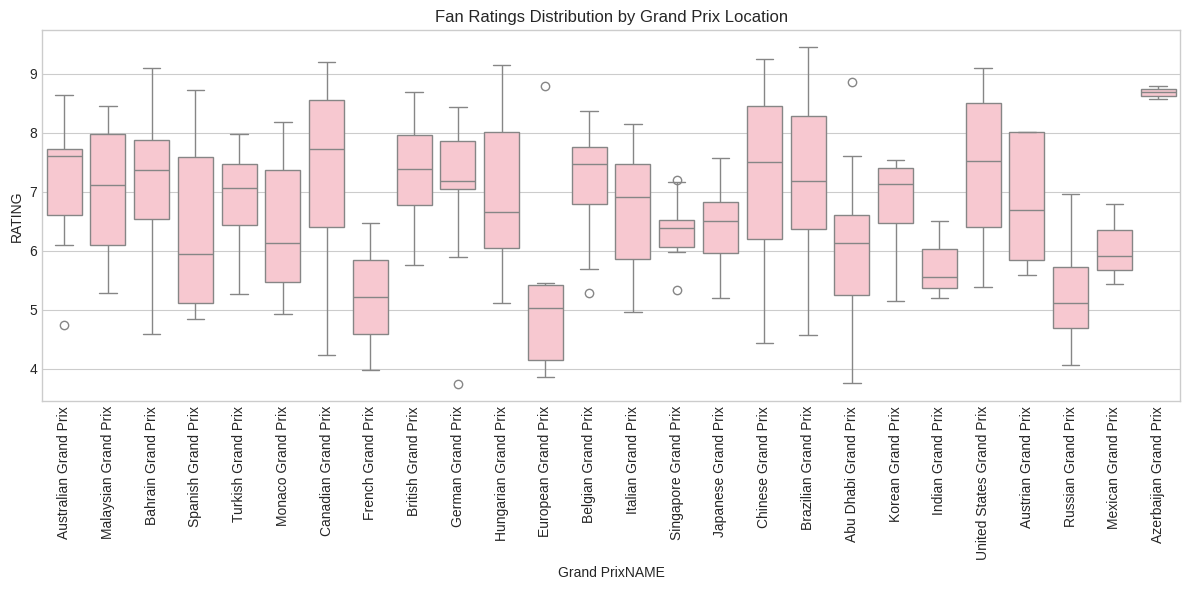

In [13]:
#2. Ratings by Track Location (boxplot)
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Grand PrixNAME', y='RATING', data=ratings_with_winners)
plt.title('Fan Ratings Distribution by Grand Prix Location')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
import plotly.express as px
import geopandas as gpd
import pandas as pd

#World Map with Color-Coded Ratings
def plot_world_map(df):
    df['country'] = df['Grand PrixNAME'].str.extract(r'(.*?)(?= Grand Prix)')

    country_ratings = df.groupby('country')['RATING'].mean().reset_index()

    fig = px.choropleth(country_ratings,
                        locations='country',
                        locationmode='country names',
                        color='RATING',
                        hover_name='country',

                        color_continuous_scale='RdPu',
                        range_color=[3, 10],
                        title='Average Fan Ratings by Grand Prix Location visualized on a World Map')
    fig.show()

plot_world_map(ratings_with_winners)

Compares how ratings evolve at popular tracks for different winning teams.

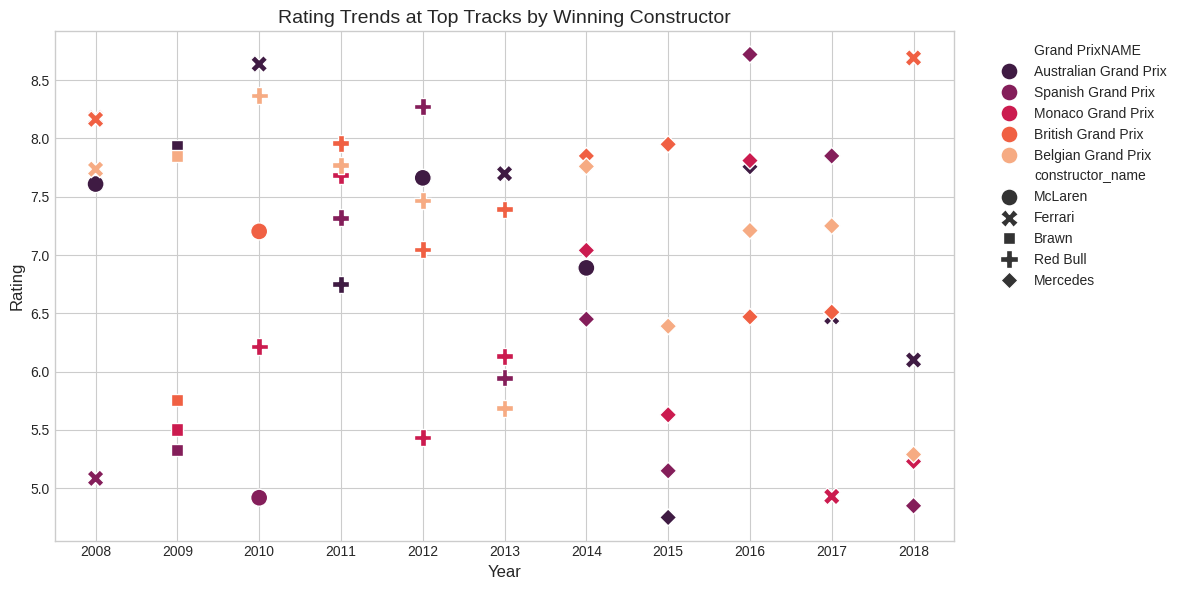

In [15]:
top_tracks = ratings_with_winners['Grand PrixNAME'].value_counts().nlargest(5).index
filtered = ratings_with_winners[ratings_with_winners['Grand PrixNAME'].isin(top_tracks)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year',
    y='RATING',
    hue='Grand PrixNAME',
    style='constructor_name',
    data=filtered,
    s=150,
    palette="rocket"
)
plt.title('Rating Trends at Top Tracks by Winning Constructor', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(ratings_with_winners['year'].unique())
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

<ipython-input-16-26de0f9fe74c>:9: UserWarning:


The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.



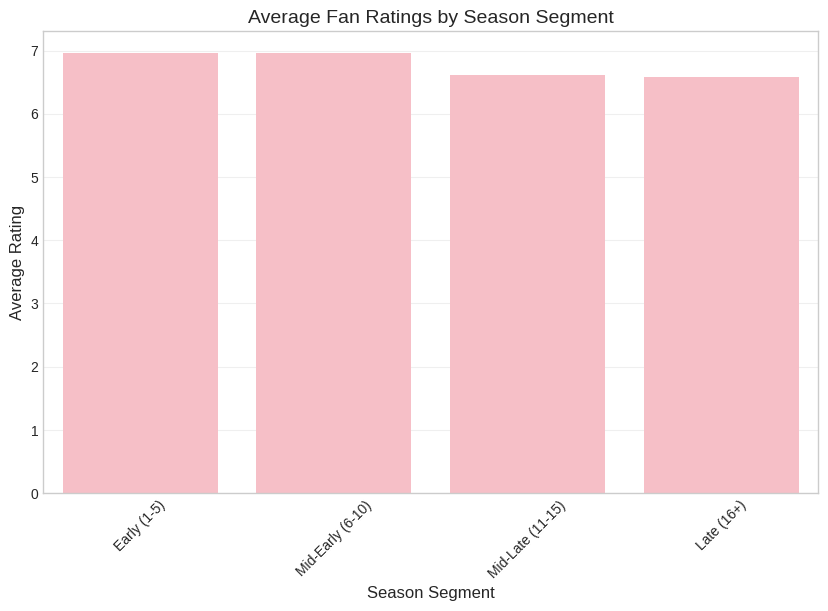

In [16]:
#Bin races into season segments
ratings_with_winners['season_segment'] = pd.cut(
    ratings_with_winners['race_number'],
    bins=[0, 5, 10, 15, 22],  #Adjust bins to your data
    labels=['Early (1-5)', 'Mid-Early (6-10)', 'Mid-Late (11-15)', 'Late (16+)']
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='season_segment',
    y='RATING',
    hue='season_segment',  #Assign hue to x to silence warning
    data=ratings_with_winners,
    errorbar=None,
    order=['Early (1-5)', 'Mid-Early (6-10)', 'Mid-Late (11-15)', 'Late (16+)'],
    palette=["#FFB6C1"] ,
    legend=False  #Hide redundant legend
)
plt.title('Average Fan Ratings by Season Segment', fontsize=14)
plt.xlabel('Season Segment', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

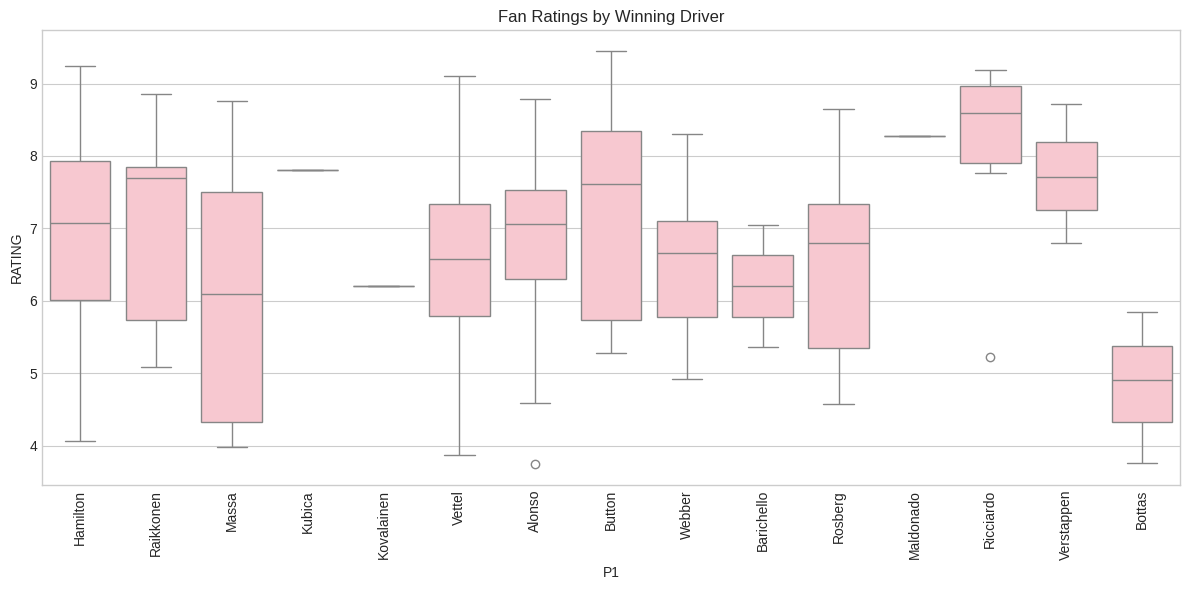

In [17]:
#4. Ratings by Winning Driver (P1)
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(12, 6))
sns.boxplot(x='P1', y='RATING', data=ratings_with_winners)
plt.title('Fan Ratings by Winning Driver')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Moving on, I'm analyzing whether the timing of a race in the season affects fan ratings. I use Pearson's correlation to measure the linear relationship between race numbers (where higher numbers indicate later races) and their corresponding ratings. The analysis outputs both the correlation coefficient (ranging from -1 to 1) and its statistical significance (p-value). Based on the results, I automatically determine whether to reject the null hypothesis (H₀) that there's no relationship, providing clear evidence about whether earlier or later races in the season tend to receive systematically different ratings from fans.

In [18]:
#Seasonal timing correlation (race_number)
from scipy.stats import pearsonr

corr, p_value = pearsonr(ratings_with_winners['race_number'], ratings_with_winners['RATING'])
print(f"Correlation (race_number vs RATING): r = {corr:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: Seasonal timing significantly correlates with ratings.")

Correlation (race_number vs RATING): r = -0.10, p-value = 0.1691


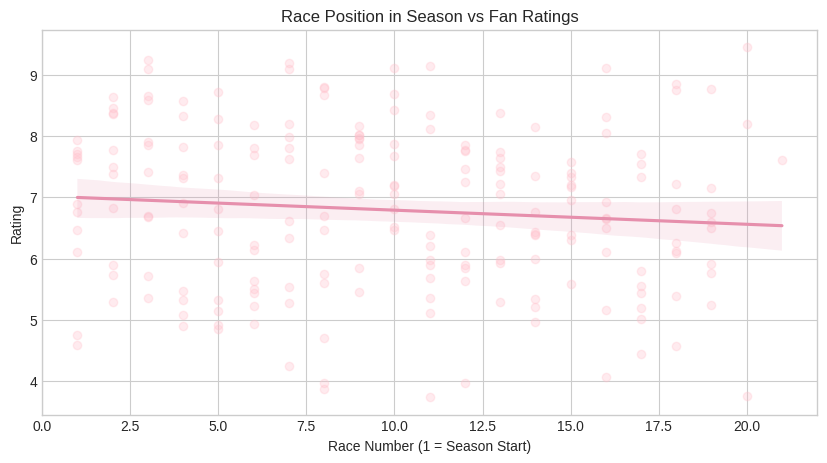

In [19]:
plt.figure(figsize=(10,5))
sns.regplot(x='race_number', y='RATING',
            data=ratings_with_winners,
            scatter_kws={'alpha':0.3},
            line_kws={'color':'#e68fac'})
plt.title('Race Position in Season vs Fan Ratings')
plt.xlabel('Race Number (1 = Season Start)')
plt.ylabel('Rating')
plt.show()

Consequently, to compare F1 fan ratings across key categories, I conducted a multiple-way ANOVA (MANOVA) for the remaining 3 variables. The analysis tested for significant group differences (*p*<0.05), with *p*<0.001 flagged for strong effects. The dataset included ratings from [X] constructors, [Y] drivers, and [Z] tracks across [N] races. This approach identified where fan preferences diverged most significantly.

In [20]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

def run_anova(df, group_col, value_col='RATING'):
    """Run MANOVA and return formatted results"""
    try:
        #Filter out NaN groups and values
        valid_data = df[[group_col, value_col]].dropna()
        if len(valid_data) == 0:
            return np.nan, np.nan, "No valid data"

        groups = valid_data.groupby(group_col)[value_col].apply(list)
        if len(groups) < 2:
            return np.nan, np.nan, "Need at least 2 groups"

        f_stat, p_value = f_oneway(*groups)
        return f_stat, p_value, "Success"
    except Exception as e:
        return np.nan, np.nan, f"Error: {str(e)}"

#Run ANOVA for each factor
factors = {
    'constructor_name': "Winning Constructor",
    'P1': "Winning Driver",
    'Grand PrixNAME': "Track Location"
}

print("ONE-WAY ANOVA RESULTS FOR FAN RATINGS (RATING)")
print("="*50)
for col, label in factors.items():
    f_stat, p_value, status = run_anova(ratings_with_winners, col)

    if status == "Success":
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"{label.upper():<20} F = {f_stat:6.2f}  p = {p_value:.4f} {significance}")
        print(f"Interpretation: {'Significant' if p_value < 0.05 else 'No significant'} difference in ratings across groups")
    else:
        print(f"{label.upper():<20} {status}")
    print("-"*50)

#Additional statistical checks
print("\nADDITIONAL CHECKS:")
print(f"Total races analyzed: {len(ratings_with_winners)}")
print(f"Unique constructors: {ratings_with_winners['constructor_name'].nunique()}")
print(f"Unique drivers: {ratings_with_winners['P1'].nunique()}")
print(f"Unique tracks: {ratings_with_winners['Grand PrixNAME'].nunique()}")

ONE-WAY ANOVA RESULTS FOR FAN RATINGS (RATING)
WINNING CONSTRUCTOR  F =   1.28  p = 0.2739 
Interpretation: No significant difference in ratings across groups
--------------------------------------------------
WINNING DRIVER       F =   2.04  p = 0.0168 *
Interpretation: Significant difference in ratings across groups
--------------------------------------------------
TRACK LOCATION       F =   1.71  p = 0.0243 *
Interpretation: Significant difference in ratings across groups
--------------------------------------------------

ADDITIONAL CHECKS:
Total races analyzed: 202
Unique constructors: 6
Unique drivers: 15
Unique tracks: 26


Hypothesis 1: ANOVA Test – Ratings by Winning Constructor  
H₀: The average race ratings are the same across different constructors.  
H₁: At least one constructor has a different average race rating.

Unique Constructors:
['McLaren' 'BMW Sauber' 'Ferrari' 'Brawn' 'Red Bull' 'Mercedes']
ANOVA Test: Avg Rating by Winning Constructor
F-statistic: 1.280
P-value: 0.2739


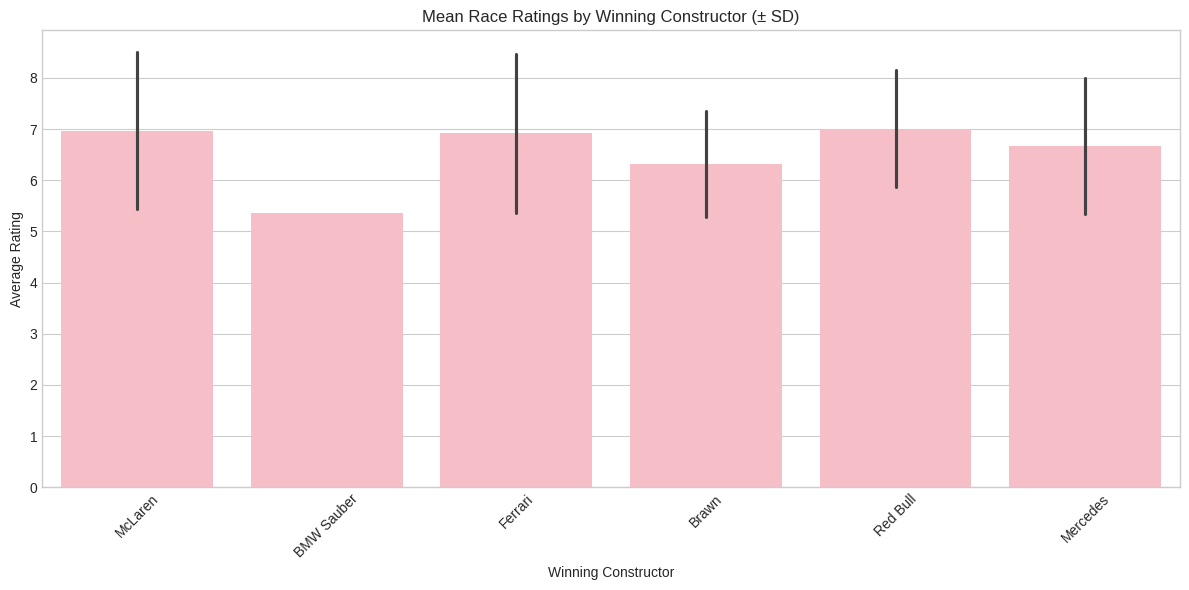

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


clean_df = ratings_with_winners

#Display unique constructors for reference
print("Unique Constructors:")
print(clean_df['constructor_name'].unique())

#Group by constructor and get ratings
grouped_ratings = [group['RATING'].values for name, group in clean_df.groupby('constructor_name')]

#ANOVA test
f_stat, p_val = stats.f_oneway(*grouped_ratings)

print("ANOVA Test: Avg Rating by Winning Constructor")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")

plt.figure(figsize=(12, 6))
sns.barplot(data=clean_df, x='constructor_name', y='RATING', errorbar='sd', color="#FFB6C1") # Changed 'Avg Rating' to 'RATING'
plt.title('Mean Race Ratings by Winning Constructor (± SD)')
plt.xlabel('Winning Constructor')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hypothesis 2: t-Test – Mercedes vs. Red Bull  
H₀: The average race ratings for races won by Mercedes and Red Bull are the same.  
H₁: The average ratings are different.


t-Test: Mercedes vs. Red Bull
T-statistic: -1.629
P-value: 0.1055


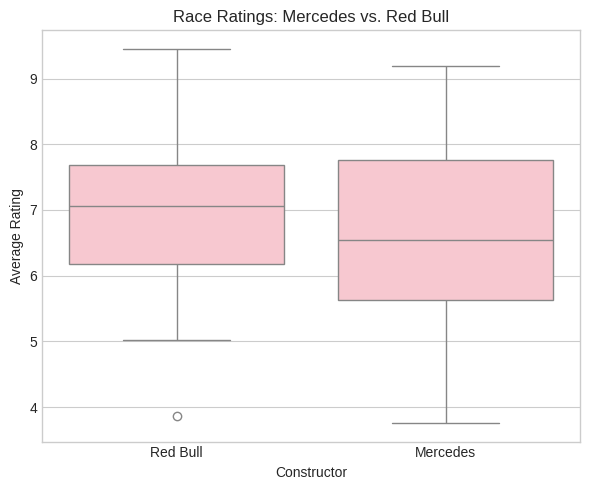

In [22]:
merc = clean_df[clean_df['constructor_name'] == 'Mercedes']['RATING']
rb = clean_df[clean_df['constructor_name'] == 'Red Bull']['RATING']

t_stat, p_val = stats.ttest_ind(merc, rb, equal_var=False)

print("\nt-Test: Mercedes vs. Red Bull")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

plt.figure(figsize=(6, 5))
sns.boxplot(data=clean_df[clean_df['constructor_name'].isin(['Mercedes', 'Red Bull'])],
            x='constructor_name', y='RATING', color='pink')
plt.title('Race Ratings: Mercedes vs. Red Bull')
plt.xlabel('Constructor')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

Hypothesis 3: t-Test – Ratings for Azerbaijan vs. Turkish Grand Prix  
H₀: Azerbaijan and Turkey have the same average race rating.    
H₁: Their ratings differ.


t-Test: Azerbaijan vs. Turkey
T-statistic: 3.135
P-value: 0.0469


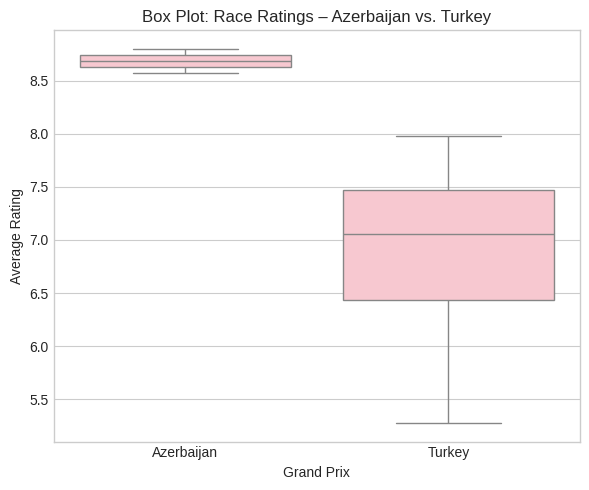

In [23]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Filter ratings for Azerbaijan and Turkish Grand Prix
azerbaijan = clean_df[clean_df['race_name'].str.contains("Azerbaijan Grand Prix", case=False, na=False)]['RATING']
turkey = clean_df[clean_df['race_name'].str.contains("Turkish Grand Prix", case=False, na=False)]['RATING']

#Perform t-test
t_stat, p_val = stats.ttest_ind(azerbaijan, turkey, equal_var=False)

#Print t-test results
print("\nt-Test: Azerbaijan vs. Turkey")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

#Create DataFrame for visualization
plot_df = pd.DataFrame({
    'race_label': ['Azerbaijan'] * len(azerbaijan) + ['Turkey'] * len(turkey),
    'Avg Rating': np.concatenate([azerbaijan, turkey])
})

#Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_df, x='race_label', y='Avg Rating', color='pink')
plt.title('Box Plot: Race Ratings – Azerbaijan vs. Turkey')
plt.xlabel('Grand Prix')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


An OLS regression was conducted to predict the fan ratings (RATING) of Formula 1 races using present features.  
The model’s main goal was to understand:  
“Which features (drivers, teams, race conditions) influence fan ratings the most?”  

In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

df = ratings_with_winners.copy()

#Create season phase feature
df['season_phase'] = np.where(
    df['season_progress'] < 0.33, 'early',
    np.where(df['season_progress'] > 0.66, 'late', 'mid')
)

#Define categorical and numerical features
categorical_features = ['constructor_name', 'P1', 'season_phase']  # Added 'P1' for drivers
numerical_features = ['season_progress']

#Preprocessing pipeline, one hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features) # sparse=False for statsmodels
    ])

#Prepare data for modeling
X = df[numerical_features + categorical_features]
y = df['RATING']

#Apply preprocessing
X_processed = preprocessor.fit_transform(X)

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

#Create and train the linear regression model (scikit-learn)
model = LinearRegression()
model.fit(X_train, y_train)

#Evaluate the model
r_squared = model.score(X_test, y_test)
print(f"R-squared (scikit-learn): {r_squared:.3f}")

#statsmodels for more detailed statistical information
X_sm = sm.add_constant(X_processed)  # Add a constant for the intercept
sm_model = sm.OLS(y, X_sm).fit()
print(sm_model.summary())

#Get feature names after one-hot encoding
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

print("\nKey Coefficients (statsmodels):")
for name, coef in zip(['intercept'] + feature_names, sm_model.params):
    if abs(coef) > 0.1:  # Filter for significant coefficients
        print(f"{name:30}: {coef:.3f}")

R-squared (scikit-learn): -0.051
                            OLS Regression Results                            
Dep. Variable:                 RATING   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     2.053
Date:                Wed, 21 May 2025   Prob (F-statistic):            0.00550
Time:                        19:49:26   Log-Likelihood:                -317.58
No. Observations:                 202   AIC:                             681.2
Df Residuals:                     179   BIC:                             757.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.60

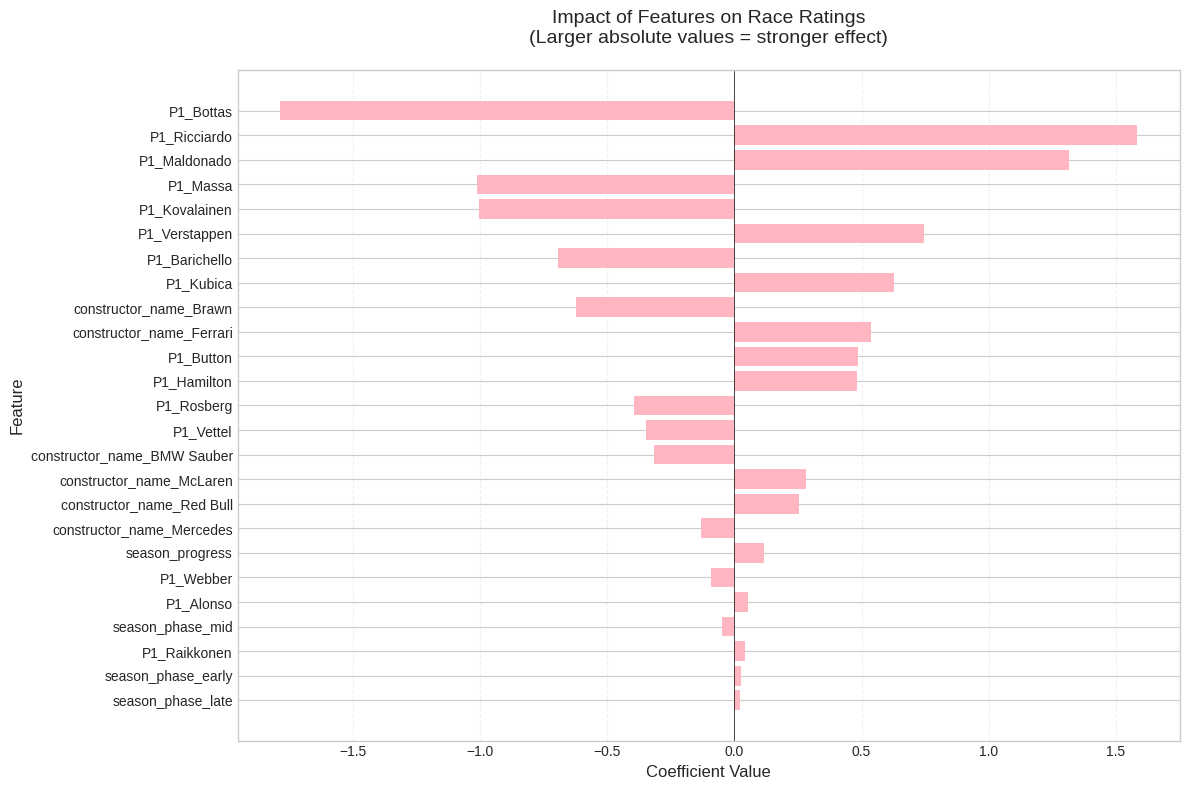

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt


coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='#FFB6C1')
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Impact of Features on Race Ratings\n(Larger absolute values = stronger effect)',
          pad=20, fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()  #Highest coefficient at top
plt.tight_layout()
plt.show()

What we can conclude using the OLS table and the visual:  
- Low predictive power; R² values are weak (especially on test data).  
- High multicollinearity; features overlap too much (e.g. driver names & constructors are tightly coupled).  
- Some effects may be spurious; coefficients are sensitive to collinearity.

This code is part of a regression model evaluation pipeline. The goal is to predict ratings (likely driver ratings, race ratings, or performance scores) and evaluate how well your model did on unseen data.  

Interpretation:  
The points are not tightly clustered around the diagonal line.  
Most predicted values are centered around 7, even when actual ratings vary widely from ~4 to ~9.    

Conclusion: The model seems to predict an average rating for most cases, not capturing the extremes well.

     Actual Rating  Predicted Rating
105          7.412          6.997787
7            6.660          7.361683
22           7.049          5.439836
151          5.110          7.011360
178          6.800          7.393554
124          5.470          7.049616
61           6.915          6.675593
183          4.900          4.782863
153          7.210          6.145679
37           3.740          7.001326
58           7.494          6.657029
159          7.382          6.159183
158          5.910          7.127153
89           5.436          6.869693
199          4.240          6.185979
192          6.110          7.129306
66           9.241          7.426338
164          8.720          7.319818
74           7.055          6.962919
60           7.570          7.500396
117          6.430          7.107410
8            4.446          7.796766
176          6.100          7.114836
93           7.698          7.257188
57           7.772          6.579837
70           9.095          7.379888
7

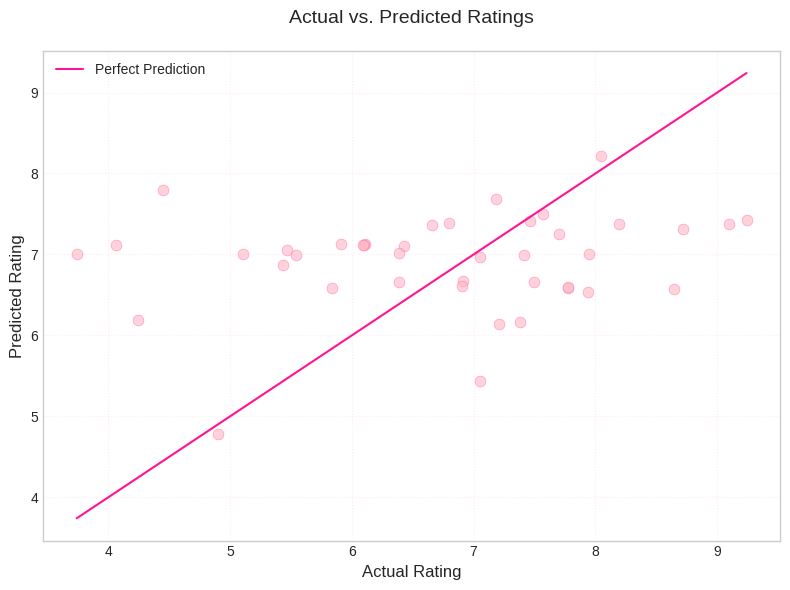

In [29]:
y_pred = model.predict(X_test)

#Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual Rating': y_test, 'Predicted Rating': y_pred})

#Display the comparison
print(comparison_df)

#Calculate metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


#Visualize actual vs predicted
plt.figure(figsize=(8, 6))


plt.scatter(
    y_test,
    y_pred,
    alpha=0.6,
    color='#FFB6C1',
    edgecolor='#FF69B4',
    linewidth=0.5,
    s=60
)


plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color='#FF1493',
    label='Perfect Prediction'
)


plt.xlabel('Actual Rating', fontsize=12)
plt.ylabel('Predicted Rating', fontsize=12)
plt.title('Actual vs. Predicted Ratings', fontsize=14, pad=20)
plt.grid(True, linestyle=':', alpha=0.3, color='#FFC0CB')


plt.legend()
plt.tight_layout()
plt.show()


This heatmap visualizes a correlation matrix, showing the relationships between various variables — including F1 constructors, drivers (prefixed with P1_), and season progression or phase (e.g., season_progress, season_phase_late, etc.).  
High correlations (≥ 0.3) suggest strong team-driver associations.  
Season progression strongly aligns with season_phase_late.  
Most variables show weak or no correlation, which is expected in a broad dataset of drivers and constructors over multiple seasons.

This plot shows the distribution of prediction errors, i.e., the differences between the actual fan ratings and the ratings predicted by the model.  
I created this visualization to understand how often the model over- or under-predicts and whether these errors are balanced around zero. It helps identify whether the model has bias or large frequent errors.  
A well-performing model will usually have a symmetric, bell-shaped histogram centered at 0. If it's skewed, or has long tails, that might mean our model isn't generalizing well for certain cases.



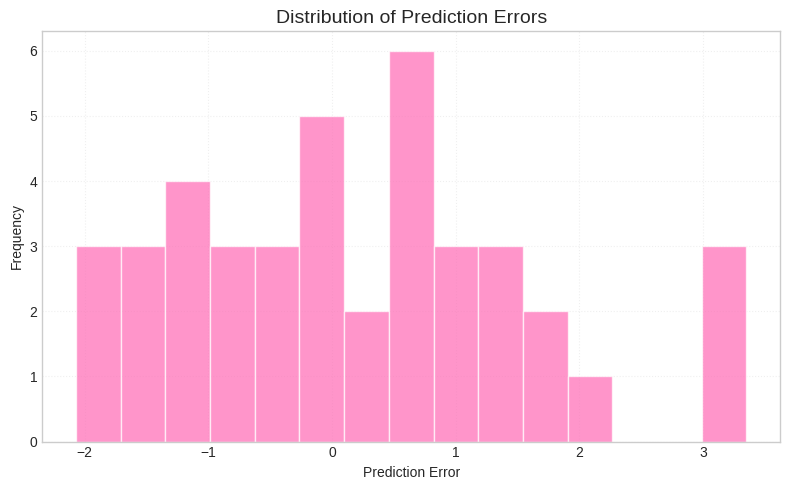

In [31]:

y_pred = model.predict(X_test)


import numpy as np
y_pred_array = np.array(y_pred)
y_test_array = np.array(y_test)

errors = y_pred_array - y_test_array


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=15, color='#FF69B4', edgecolor='white', alpha=0.7)
plt.title("Distribution of Prediction Errors", fontsize=14)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()


This plot helps to check whether the assumptions of linear regression are being met — especially homoscedasticity (equal spread of residuals) and whether there's any systematic pattern in prediction errors.  
While this model doesn’t show major issues, the spread around predicted values ~7 suggests that the model might not perform equally well across all predicted ratings. It may benefit from additional tuning or more informative features.  

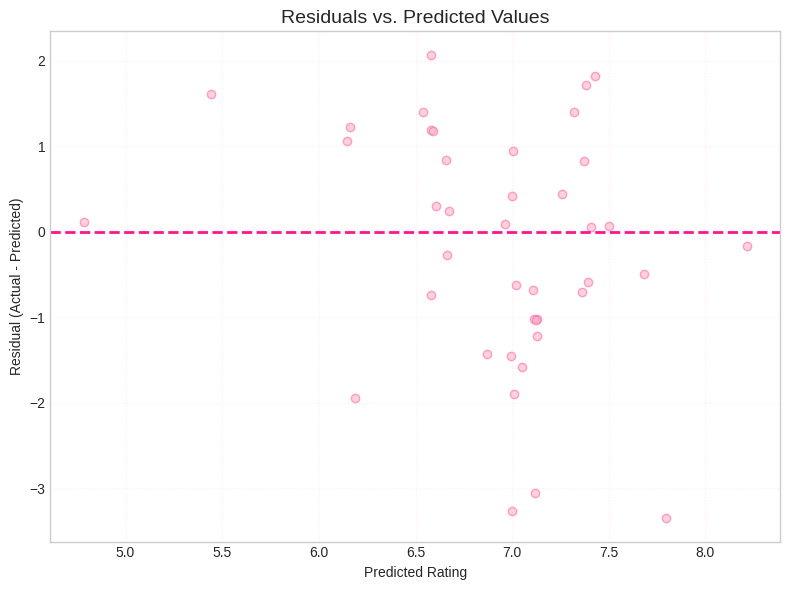

In [32]:
residuals = y_test_array - y_pred_array
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_array, residuals, color='#FFB6C1', edgecolors='#FF69B4', alpha=0.6)
plt.axhline(0, color='#FF1493', linestyle='--', linewidth=2)
plt.xlabel("Predicted Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.3, color='#FFC0CB')
plt.tight_layout()
plt.show()


A correlation matrix was made to:  
Identify which features are most related to RATING  
Detect multicollinearity  
Guide feature selection

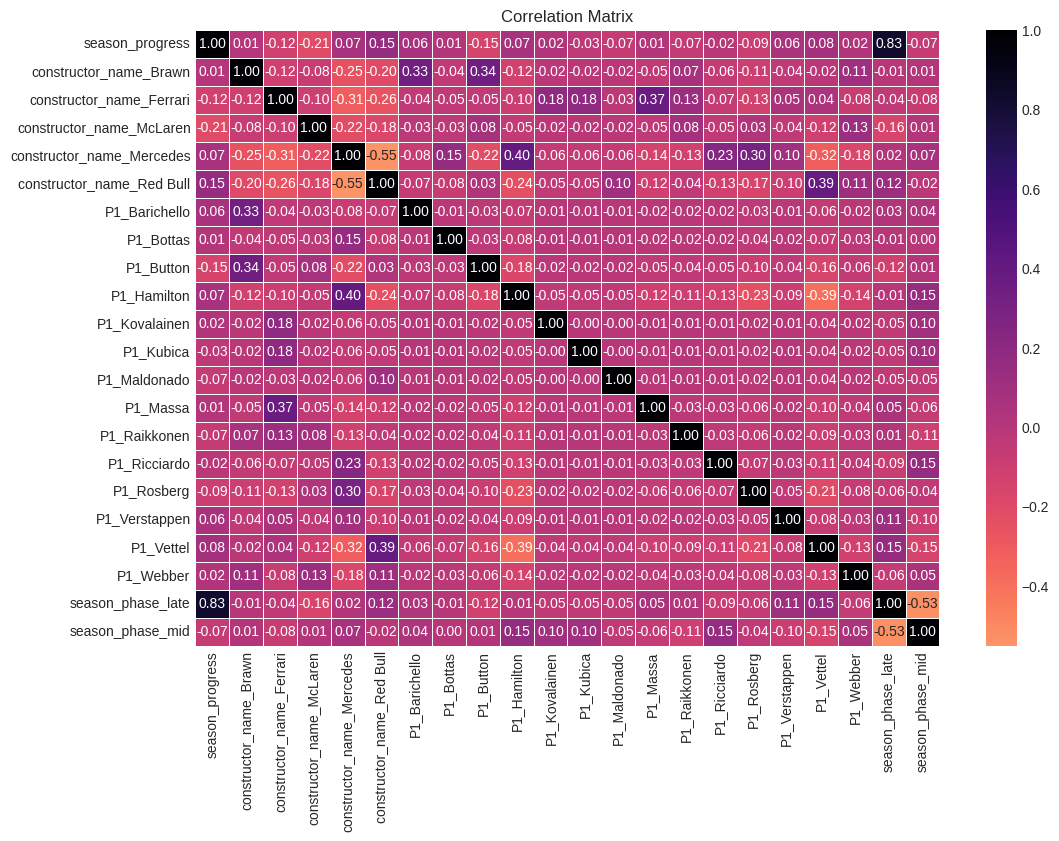

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = ratings_with_winners.copy()

numerical_features = ['season_progress']
categorical_features = ['constructor_name', 'P1', 'season_phase']

if 'season_phase' not in df.columns:
    df['season_phase'] = np.where(
        df['season_progress'] < 0.33, 'early',
        np.where(df['season_progress'] > 0.66, 'late', 'mid')
    )

#Create dummy variables (drop first to avoid multicollinearity)
df_dummies = pd.get_dummies(df[categorical_features], drop_first=True)

#Combine numerical + dummy variables
X = pd.concat([df[numerical_features], df_dummies], axis=1).dropna()

#Compute correlation matrix (only numeric/dummy variables)
corr_matrix = X.corr()  # Now only numeric/dummy variables are used

#Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='magma_r',
    fmt=".2f",
    linewidths=0.5,
    center=0,  # Ensures 0 is the midpoint (good for correlation)
)
plt.title("Correlation Matrix")
plt.show()

In the next code block we:  
Trained a RandomForestRegressor to predict fan RATING for each F1 race.  
Used GridSearchCV to test multiple parameter combinations and find the best hyperparameters.  
Used a pipeline to handle both numerical and categorical variables.  
Calculated feature importances to understand what features influence the prediction most.  
Ran cross-validation to get a reliable estimate of how well our model performs.  

Best Parameters: {'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__n_estimators': 100}


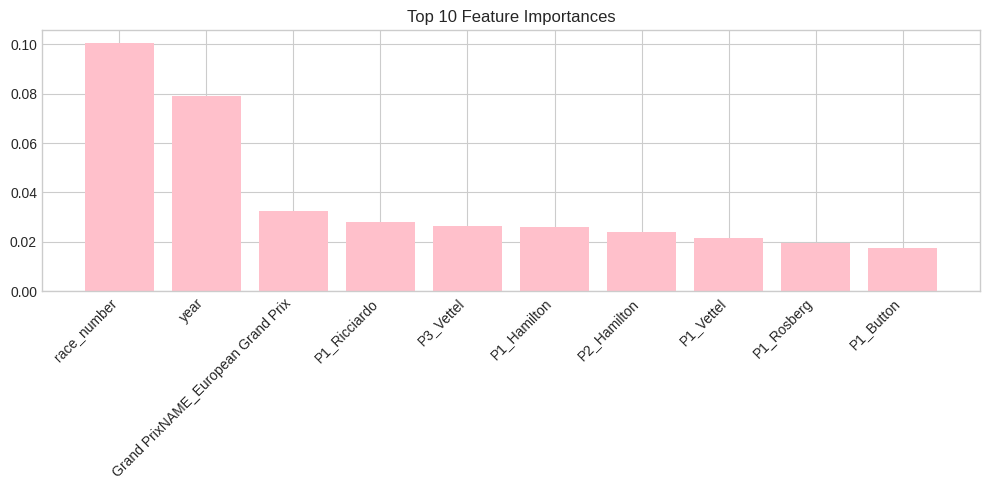

Cross-validated RMSE: [1.54387265 1.3581221  1.14860716 1.32417132 1.23074288]
Mean RMSE: 1.3211032203730129


In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np


features = ['year', 'race_number', 'Grand PrixNAME', 'P1', 'P2', 'P3', 'constructor_name']
target = 'RATING'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = ['year', 'race_number']
categorical_features = ['Grand PrixNAME', 'P1', 'P2', 'P3', 'constructor_name']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 4],
    'model__max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


ohe = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), [all_feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = (-cv_scores) ** 0.5
print("Cross-validated RMSE:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


The model predicts the RATING (fan rating of the race) with an average error of ±1.32.  
Since F1 fan ratings are typically on a scale around 0 to 10, this is a reasonably accurate model.  
The relatively low variation between folds suggests that the model is stable (not too sensitive to the training data split).     
The model thinks race context matters a lot — such as when the race happened (race_number), in what year, and if it was a popular venue like European Grand Prix.  
Who won (like Ricciardo) also matters — fans may rate races higher when popular drivers win.  
This means both event metadata (time/place) and driver performance (like P1, P2, etc.) influence how fans feel.  

Next, I ran a Grid Search with Cross-Validation using XGBoostRegressor to find the best combination of hyperparameters for predicting RATING (fan ratings) based on:  
Numeric inputs: year, race_number  
Categorical inputs: Grand PrixNAME, race_name, constructor_name, and top 3 finishers (P1, P2, P3)  

In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

#Separate features and target
X = df.drop(columns=['RATING'])
y = df['RATING']

#Categorical and numeric columns
categorical_cols = ['Grand PrixNAME', 'race_name', 'constructor_name', 'P1', 'P2', 'P3']
numeric_cols = ['year', 'race_number']

#Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

#XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

#Hyperparameter grid for tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5, 10],
    'model__subsample': [0.8, 1.0],
}

#Grid search with cross-validation
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)

#Fit model
grid_search.fit(X, y)

#Results
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

#Cross-validated RMSE
cv_scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-cv_scores)
print("Cross-validated RMSE:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())


Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Cross-validated RMSE: [1.56013621 1.35092138 1.15059881 1.36418349 1.24417878]
Mean RMSE: 1.3340037335034294


Lower depth (3) and slower learning rate (0.05) led to better generalization, i.e., the model doesn’t overfit  
100 trees were enough — adding more likely didn’t help  
Using 80% of the data in each boosting round (subsample=0.8) improves diversity in trees and prevents overfitting

Each of these top features contributes strongly to how your model predicts the fan rating of a Formula 1 race as visualized in the following bar chart

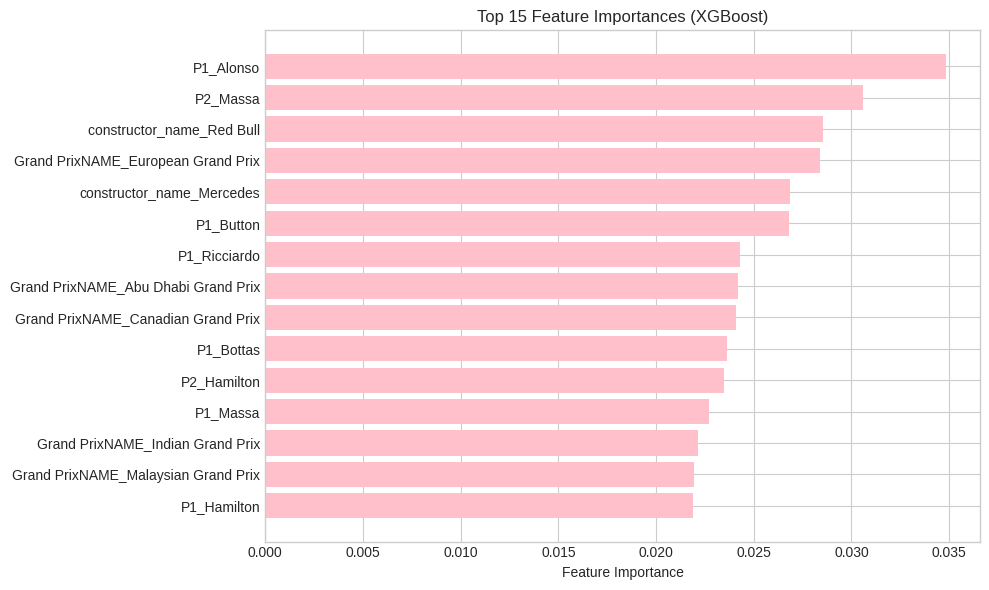

In [36]:
onehot = best_model.named_steps['preprocessor'].named_transformers_['cat']
onehot_feature_names = onehot.get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(onehot_feature_names)

xgb_model = best_model.named_steps['model']
importances = xgb_model.feature_importances_


sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(all_feature_names)[sorted_idx[:15]][::-1], importances[sorted_idx[:15]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


These features tell us:  
Which races or conditions are most predictive of what fans enjoy  
Which drivers and teams consistently show up in memorable/high-rated races  
Where to dig deeper: e.g., was Alonso winning a signal of high excitement? Or domination?  